In [115]:
import pyodbc
print(pyodbc.drivers())
conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=157.119.230.120,4071;"
    "Database=PowerBI_LISV2;"
    "UID=sa;"
    "PWD=Y0m@Sql.!.123;"
)

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

['SQL Server', 'SQL Server Native Client 11.0', 'ODBC Driver 11 for SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'ODBC Driver 17 for SQL Server']


In [97]:
import pandas as pd
conn = pyodbc.connect(conn_str)

In [98]:
schemas = ['AmulManagement','BajajMTManagement','BrillonMTManagement','ColgateManagement','DanoneMTManagement','EvereadyManagement','GCPLManagement','IDAMManagement',
           'KRBLMTManagement','MTRManagement',
          'ReckittManagement','WiproGranammaManagement','ZydusMTManagement']

In [99]:
final_df = pd.DataFrame()

for schema in schemas:
    query = f"""
    SELECT DISTINCT
        '{schema}' AS SchemaName,
        LISStoreCode,StoreName,
        PERCENTILE_CONT(0.5) 
            WITHIN GROUP (ORDER BY CAST(InLatitude AS FLOAT)) 
            OVER (PARTITION BY LISStoreCode) AS MedianLatitude,
        PERCENTILE_CONT(0.5) 
            WITHIN GROUP (ORDER BY CAST(InLongitude AS FLOAT)) 
            OVER (PARTITION BY LISStoreCode) AS MedianLongitude
    FROM [PowerBI_LISV2].[{schema}].[ISPStoreAttendance_NormalExport]
    WHERE [LISStoreCode] NOT LIKE '%SP'
      AND lower([LISStoreCode]) NOT LIKE '%test%';
    """
    
    df = pd.read_sql(query, conn)
    print({schema})
    final_df = pd.concat([final_df, df], ignore_index=True)


C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_10328\1454546604.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


{'AmulManagement'}
{'BajajMTManagement'}
{'BrillonMTManagement'}
{'ColgateManagement'}
{'DanoneMTManagement'}
{'EvereadyManagement'}
{'GCPLManagement'}
{'IDAMManagement'}
{'KRBLMTManagement'}
{'MTRManagement'}
{'ReckittManagement'}
{'WiproGranammaManagement'}
{'ZydusMTManagement'}


In [100]:
final_df.head()

SchemaName    LISStoreCode             StoreName  MedianLatitude  \
0  AmulManagement  AMLGTStore-005        JHANSI KI RANI       23.024072   
1  AmulManagement  AMLGTStore-026           TAKSHASHILA       23.010863   
2  AmulManagement  AMLGTStore-030  Kankaria-Gordhanwadi       23.002228   
3  AmulManagement  AMLGTStore-054         NIKOL Parlour       23.041178   
4  AmulManagement  AMLGTStore-059            GOTILA-PRL       23.041205   

   MedianLongitude  
0        72.532385  
1        72.651216  
2        72.595438  
3        72.661668  
4        72.493581

In [101]:
# final_df.replace('', np.nan, inplace=True)

# Remove rows with any NaN values (blank or null)
# final_df_cleaned = df.dropna()
final_df_cleaned = final_df

In [102]:
final_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42545 entries, 0 to 42544
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SchemaName       42545 non-null  object 
 1   LISStoreCode     42545 non-null  object 
 2   StoreName        42545 non-null  object 
 3   MedianLatitude   42545 non-null  float64
 4   MedianLongitude  42545 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.6+ MB


In [103]:
final_df.to_csv('final_df_latlong.csv')

In [104]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

from sklearn.preprocessing import StandardScaler
from math import radians

In [105]:
final_df_cleaned['MedianLatitude'] = final_df_cleaned['MedianLatitude'].astype(float)
final_df_cleaned['MedianLongitude'] = final_df_cleaned['MedianLongitude'].astype(float)

In [106]:
# Convert lat-long to NumPy array
coords = final_df_cleaned[['MedianLatitude', 'MedianLongitude']].to_numpy()

In [107]:
# Standardize coordinates
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

In [108]:
db = DBSCAN(eps=0.000197, min_samples=5, metric='haversine').fit(coords_scaled)

In [109]:
final_df_cleaned['cluster_id'] = db.labels_

In [110]:
final_df_cleaned.head()

SchemaName    LISStoreCode             StoreName  MedianLatitude  \
0  AmulManagement  AMLGTStore-005        JHANSI KI RANI       23.024072   
1  AmulManagement  AMLGTStore-026           TAKSHASHILA       23.010863   
2  AmulManagement  AMLGTStore-030  Kankaria-Gordhanwadi       23.002228   
3  AmulManagement  AMLGTStore-054         NIKOL Parlour       23.041178   
4  AmulManagement  AMLGTStore-059            GOTILA-PRL       23.041205   

   MedianLongitude  cluster_id  
0        72.532385          -1  
1        72.651216          -1  
2        72.595438          -1  
3        72.661668          -1  
4        72.493581          -1

In [111]:
final_df_cleaned.to_csv('final_df_cleaned.csv')

#### K Means Clustering

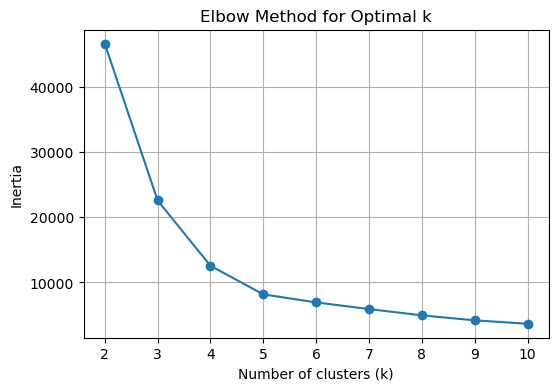

     LISStoreCode             StoreName  MedianLatitude  MedianLongitude  \
0  AMLGTStore-005        JHANSI KI RANI       23.024072        72.532385   
1  AMLGTStore-026           TAKSHASHILA       23.010863        72.651216   
2  AMLGTStore-030  Kankaria-Gordhanwadi       23.002228        72.595438   
3  AMLGTStore-054         NIKOL Parlour       23.041178        72.661668   
4  AMLGTStore-059            GOTILA-PRL       23.041205        72.493581   

   cluster_kmeans  
0               1  
1               1  
2               1  
3               1  
4               1  


In [116]:
# 2. Take only lat-long columns
X = final_df_cleaned[['MedianLatitude', 'MedianLongitude']].values

# 3. Scale features (important for distance-based algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. (Optional) Use elbow method to choose k
inertias = []
K_range = range(2, 11)  # try 2 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

# 5. Fit final KMeans with chosen k
k = 5  # <-- change based on elbow plot / business logic
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
final_df_cleaned['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# 6. Save clustered data
df.to_csv("final_df_latlong_clustered_kmeans.csv", index=False)
print(final_df_cleaned[['LISStoreCode', 'StoreName', 'MedianLatitude', 'MedianLongitude', 'cluster_kmeans']].head())


In [117]:
final_df_cleaned.head()

SchemaName    LISStoreCode             StoreName  MedianLatitude  \
0  AmulManagement  AMLGTStore-005        JHANSI KI RANI       23.024072   
1  AmulManagement  AMLGTStore-026           TAKSHASHILA       23.010863   
2  AmulManagement  AMLGTStore-030  Kankaria-Gordhanwadi       23.002228   
3  AmulManagement  AMLGTStore-054         NIKOL Parlour       23.041178   
4  AmulManagement  AMLGTStore-059            GOTILA-PRL       23.041205   

   MedianLongitude  cluster_id  cluster_kmeans  
0        72.532385          -1               1  
1        72.651216          -1               1  
2        72.595438          -1               1  
3        72.661668          -1               1  
4        72.493581          -1               1

In [118]:
final_df_cleaned.to_csv('final_df_cleaned_km.csv')

In [119]:
# 2. Coordinates in radians (required for haversine metric)
coords = np.radians(final_df_cleaned[['MedianLatitude', 'MedianLongitude']].values)

# 3. Define distance threshold
kms_per_radian = 6371.0088
cluster_radius_km = 5  # max distance between points in same cluster (e.g., 5 km)
eps = cluster_radius_km / kms_per_radian

# 4. Run DBSCAN
db = DBSCAN(eps=eps, min_samples=5, metric='haversine')
labels = db.fit_predict(coords)

# 5. Attach cluster labels
final_df_cleaned['cluster_dbscan'] = labels   # -1 means noise / outlier

# 6. Save result
final_df_cleaned.to_csv("final_df_latlong_clustered_dbscan.csv", index=False)
